# Supplemental analysis
---

### Overview
The purpose of this notebook is to analyze single-cell motility statistics to show:
1. That mutant strains of *C. reinhardtii* cells with motility defects exhibit reduced motility as measured by maximum sprint length and mean linear speed.
2. The effects of each drug on wild-type *C. reinhardtii* cells

Output from this notebook was used to generate supplemental figures 1 and 2 in the [pub](https://doi.org/10.57844/arcadia-fe2a-711e).

In [1]:
import sys

sys.path.append("../src")

In [2]:
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stats_testing import kde_plot_with_stats

apc.mpl.setup()

### Define variables
- Define wild-typle vs mutant strains.
- Define controls vs drugs.
- Define which motility metrics to include in the PCA.

In [3]:
# strains
wild_type = "CC-125"
mutant_strains = ["CC-2670", "CC-3707"]

# drugs
controls = ["dmso", "h2o"]
drugs = ["atp", "dyn", "ibu", "lin", "tak", "tor"]
concentration = 50  # µM

# motility metrics
metrics = [
    "max_sprint_length",
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_linear_speed",
    "mean_angular_speed",
    "pivot_rate",
]

# rename certain variables in the plots
rename_for_plot = {
    "CC-125": "wild type",
    "CC-2670": "ida4 mutant",
    "CC-3707": "cpc1 mutant",
    "max_sprint_length": "Max sprint length",
    "confinement_ratio": "Confinement ratio",
    "mean_curvilinear_speed": "Mean curvilinear speed",
    "mean_linear_speed": "Mean linear speed",
    "mean_angular_speed": "Mean angular speed",
    "pivot_rate": "Pivot rate",
}

# define color palette
color_palette = {
    "wild type": apc.chateau,
    "ida4 mutant": apc.vital,
    "cpc1 mutant": apc.tangerine,
    "wild type + drug": apc.charcoal,
    "ida4 mutant + drug": apc.lapis,
    "cpc1 mutant + drug": apc.dragon,
}

# show color palette
color_palette

{'wild type':    chateau #BAB0A8,
 'ida4 mutant':    vital #73B5E3,
 'cpc1 mutant':    tangerine #FFB984,
 'wild type + drug':    charcoal #484B50,
 'ida4 mutant + drug':    lapis #2B65A1,
 'cpc1 mutant + drug':    dragon #C85152}

### Load summary motility statistics
Load dataset of summary motility statistics from two hours post-treatment.

In [4]:
motility_csv = Path(
    "../data/single-cell-motility-assay/single-cell-motility-assay_summary-statistics.csv"
)
motility_dataframe = pd.read_csv(motility_csv)
motility_dataframe.head()

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,strain,drug,hours_in_drug,concentration,well_ID
0,20.704225,230.867728,147.046824,7.562634,0.636931,11.150754,7.102262,1.526070,2.0,17,0.073635,15,CC-125,tor,2,12.5,WellA01
1,11.901408,382.449800,125.138478,17.248704,0.327202,32.134835,10.514594,2.686931,2.0,21,0.054909,15,CC-125,tor,2,12.5,WellA01
2,20.704225,156.499828,110.772470,7.823802,0.707812,7.558835,5.350235,2.427813,2.0,34,0.217253,15,CC-125,tor,2,12.5,WellA01
3,20.704225,411.206653,164.362285,12.917934,0.399707,19.861002,7.938587,1.467109,1.0,16,0.038910,15,CC-125,tor,2,12.5,WellA01
4,20.704225,154.341462,107.157320,6.164652,0.694287,7.454588,5.175626,2.173751,0.0,26,0.168458,15,CC-125,tor,2,12.5,WellA01


### Supplemental figure 1

Kernel density estimates of summary motility metrics for wild-type and mutant *Chlamydomonas* cells.
Supports the claims made in the pub that:
> This behavior is reflected in motility metrics like the max sprint length, which was 45% and 30% lower for ida4 and cpc1-1 mutants, respectively, and the mean linear speed, which was 44% and 56% lower for ida4 and cpc1-1 mutants, respectively (Mann–Whitney U, p < 0.001) (Supplemental Figure 1)

max_sprint_length: 44.9% lower for ida4 mutant vs wild type
max_sprint_length: 30.4% lower for cpc1 mutant vs wild type
mean_linear_speed: 43.5% lower for ida4 mutant vs wild type
mean_linear_speed: 56.0% lower for cpc1 mutant vs wild type


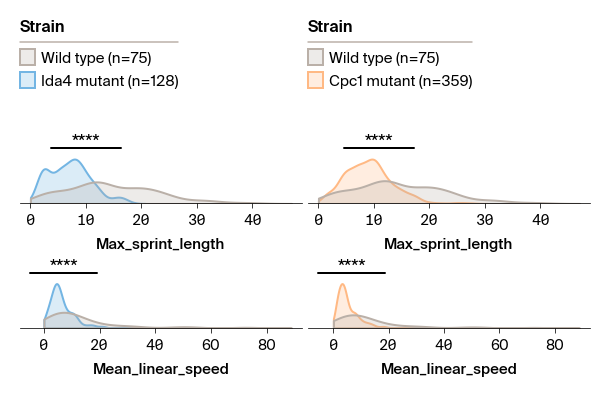

In [5]:
select_metrics = ["max_sprint_length", "mean_linear_speed"]

nrows = len(select_metrics)
ncols = len(mutant_strains)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    layout="constrained",
    figsize=(4 * ncols, 2.5 * nrows),
)

for metric_i, metric in enumerate(select_metrics):
    for mutant_i, mutant_strain in enumerate(mutant_strains):
        # configure parameters for plotting
        ax = axes[metric_i, mutant_i]
        legend = False if metric_i > 0 else True
        bw_adjust = 0.8
        clip = (0, 1e6)

        # filter to only wild-type and mutant strain in controls
        source = motility_dataframe.loc[
            (motility_dataframe["strain"].isin([wild_type, mutant_strain]))
            & (motility_dataframe["drug"].isin(controls))
        ].copy()

        # map strain names to jive with the color palette
        source["Strain"] = source["strain"].map(rename_for_plot)

        # generate KDE plots with statistical annotations
        kde_plot = kde_plot_with_stats(
            data=source,
            x_variable=metric,
            hue_variable="Strain",
            common_norm=False,
            bw_adjust=bw_adjust,
            clip=clip,
            palette=color_palette,
            fill=True,
            lw=2,
            legend=legend,
            ax=ax,
        )

        # output differences in motility metrics
        metric_mean_wildtype = source.query("strain == @wild_type")[metric].median()
        metric_mean_mutant = source.query("strain == @mutant_strain")[metric].median()
        pct_diff = (metric_mean_wildtype - metric_mean_mutant) / metric_mean_wildtype
        out = f"{metric}: {pct_diff:.1%} lower for {rename_for_plot[mutant_strain]} vs wild type"
        print(out)

        # aesthetics
        ax.set_ylabel("")
        ax.yaxis.set_ticks([])
        # ax.set_xlabel("Mean curvilinear speed")
        sns.despine(ax=ax, left=True)
        if legend:
            sns.move_legend(ax, "lower left", bbox_to_anchor=(0, 2))
        apc.mpl.style_plot(ax, monospaced_axes="both")

# save figure
filename = "../results/figure-S1.pdf"
apc.mpl.save_figure(filename)

### Supplemental figure 2

Kernel density estimates of wild-type *Chlamydomonas* mean curvilinear speed in response to each drug tested.

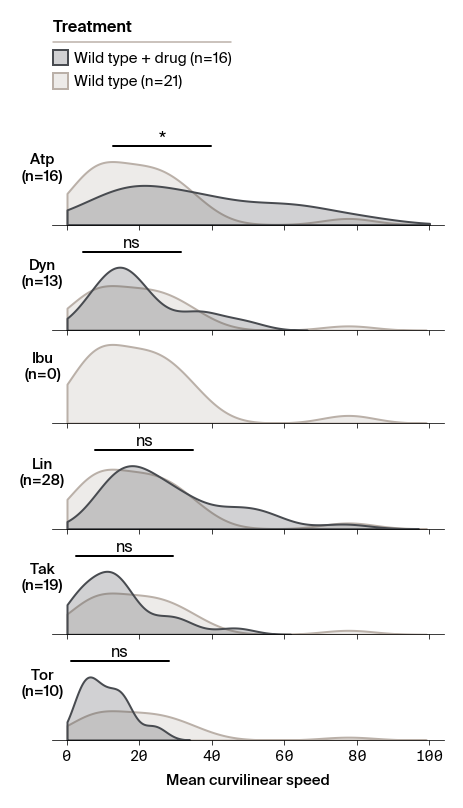

In [6]:
fig_width = apc.mpl.get_figure_dimensions(size="full_square")[0]
fig_height = 1.8 * fig_width

fig, axes = plt.subplots(
    nrows=len(drugs),
    layout="constrained",
    sharex=True,
    figsize=(fig_width, fig_height),
)
for drug_i, drug in enumerate(drugs):
    # configure parameters for plotting
    ax = axes[drug_i]
    legend = False if drug_i > 0 else True
    bw_adjust = 0.8
    clip = (0, 100)

    # filter to only wild-type strain in controls + wild-type strain on drug at 50 µM concentration
    source = motility_dataframe.loc[
        (motility_dataframe["strain"] == wild_type)
        & (motility_dataframe["drug"].isin(controls + [drug]))
        & (motility_dataframe["concentration"] == concentration)
    ].copy()

    # create a "treatment" label to jive with the color palette
    treatment = source["drug"].isin(drugs).map({True: "wild type + drug", False: "wild type"})
    source["treatment"] = treatment

    # KDE plots
    if drug != "ibu":  # no motility data available for wild type on ibudilast
        # generate the KDE plot with statistical annotations
        kde_plot = kde_plot_with_stats(
            data=source,
            x_variable="mean_curvilinear_speed",
            hue_variable="treatment",
            common_norm=False,
            bw_adjust=bw_adjust,
            clip=clip,
            palette=color_palette,
            fill=True,
            lw=2,
            legend=legend,
            ax=ax,
        )
    else:  # ibudilast gets a special plot
        # generate a KDE plot sans statistical annotations
        kde_plot = sns.kdeplot(
            data=source,
            x="mean_curvilinear_speed",
            hue="treatment",
            common_norm=False,
            bw_adjust=bw_adjust,
            clip=clip,
            palette=color_palette,
            fill=True,
            lw=2,
            legend=legend,
            ax=ax,
        )

    # aesthetics
    num_drugged_cells = source.query("drug == @drug").shape[0]
    ylabel = f"{drug}\n(n={num_drugged_cells})"
    ax.set_ylabel(ylabel, rotation=0)
    ax.yaxis.set_ticks([])
    ax.set_xlabel("Mean curvilinear speed")
    sns.despine(ax=ax, left=True)
    if legend:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 2.5))
    apc.mpl.style_plot(ax, monospaced_axes="both")

# save figure
filename = "../results/figure-S2.pdf"
apc.mpl.save_figure(filename)